# Pool Elo

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime

# Elo 

In [2]:
# Read Test Dataset 
data = pd.read_csv('data/predatorCLPClean.csv')
data['date'] = pd.to_datetime(data['date'])
fulldf = pd.read_csv("data/fulldf.csv")
fulldf['date'] = pd.to_datetime(fulldf['date'])


In [4]:
data.head()

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP


In [5]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

players = pd.concat([fulldf.playerA, fulldf.playerB] )
print(players.value_counts().index.unique())
# How many players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Niels Feijen', 'Ralf Souquet', 'Albin Ouschan',
       'Jayson Shaw', 'Eklent Kaci', 'Joshua Filler', 'David Alcaide',
       'Alex Kazakis', 'Darren Appleton',
       ...
       'Rob Metz Jr', 'José Delgado', 'Ron Hawes', 'Khanh Hoang Nguyen',
       'Mark Antony', 'Aki Heiskanen', 'Jamie White', 'Piotr Kudlik',
       'Le Quang Trun', 'Elvis Calasang'],
      dtype='object', length=1182)


1182

In [17]:
# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def expected(A, B, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate player A's expected score which is equivalent to the probability that player A wins in this 
    pool scenario since we do not track draws.
    (https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details)
    
    params
    A: Player A's current elo rating
    B: Player B's current elo rating
    ELO_WIDTH: Elo system rating change constant
    
    return 
    proba: the probability that player A wins
    '''
    proba = 1 / (1 + 10 ** ((B - A) / ELO_WIDTH))
    return proba


def update_elo(winner_elo, loser_elo, K, ELO_WIDTH = ELO_WIDTH):
    '''
    Update the winner and loser elo ratings.
    
    params
    winner_elo: Winning player's elo rating at time of match
    loser_elo: Losing player's elo rating at time of match
    K: Update parameter
    ELO_WIDTH: Elo system rating change constant
    
    return 
    winner_elo: Winning player's updated elo rating
    loser_elo: Losing player's updated elo rating
    '''
    expected_win = expected(winner_elo, loser_elo, ELO_WIDTH)
    change_in_elo = K * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo


def get_winner_loser(row):
    '''
    Get the winner and loser of the match. The winner is the player with more racks. Matches are played until 
    one player wins X number of racks (typically 5, 6, or 9).
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    if row['playerARacks'] > row['playerBRacks']: 
        winner = row["playerA"]
        loser = row["playerB"]
    else: 
        winner = row['playerB']
        loser = row['playerA']
        
    return winner, loser


# TODO: change to `run_tournament(...)`
def run_tournament3(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020).
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

In [7]:
ratings = run_tournament3(fulldf)

In [8]:
ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Jayson Shaw,1971.387195
Eklent Kaci,1924.002866
Fedor Gorst,1920.977075
Liu Haitao,1829.592959
Jung-Lin Chang,1825.054499
Maximilian Lechner,1822.385942
Joshua Filler,1793.461234
Niels Feijen,1776.715053
Alex Pagulayan,1771.201078
Francisco Sanchez Ruiz,1763.975621


In [9]:
playersCLP = pd.concat([data.playerA, data.playerB])

In [10]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in ratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(ratings.index == player)[0][0])
playersindex
names

[24, 3, 904, 5, 1, 2, 193, 25, 7, 9, 72, 46, 1170, 120, 39, 8, 86, 11, 486]

In [13]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = ratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

['Chris Melling', 'Albin Ouschan', 'Kelly Fisher', 'Eklent Kaci', 'Niels Feijen', 'Ralf Souquet', 'Chris Robinson', 'Mieszko Fortunski', 'David Alcaide', 'Darren Appleton', 'Billy Thorpe', 'Naoyuki Oi', 'Kristina Tkach', 'Roberto Gomez', 'Marc Bijsterbosch', 'Alex Kazakis', 'Casper Matikainen', 'Denis Grabe', 'Jasmin Ouschan']
                       ratings
Chris Melling      1495.785781
Albin Ouschan      1707.991433
Kelly Fisher       1482.344108
Eklent Kaci        1924.002866
Niels Feijen       1776.715053
Ralf Souquet       1678.940589
Chris Robinson     1459.936662
Mieszko Fortunski  1759.942397
David Alcaide      1692.933844
Darren Appleton    1642.581233
Billy Thorpe       1672.377227
Naoyuki Oi         1661.515937
Kristina Tkach     1469.585975
Roberto Gomez      1431.840194
Marc Bijsterbosch  1580.803032
Alex Kazakis       1664.715722
Casper Matikainen  1687.181658
Denis Grabe        1734.458389
Jasmin Ouschan     1502.096120


In [14]:
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1924.002866
Niels Feijen,1776.715053
Mieszko Fortunski,1759.942397
Denis Grabe,1734.458389
Albin Ouschan,1707.991433
David Alcaide,1692.933844
Casper Matikainen,1687.181658
Ralf Souquet,1678.940589
Billy Thorpe,1672.377227
Alex Kazakis,1664.715722


In [18]:
# TODO: delete, this is all above
# def expected(A, B, elo_width): 
#     proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
#     return( proba )

# # https://www.kaggle.com/kplauritzen/elo-ratings-in-python
# def update_elo(winner_elo, loser_elo, k, elo_width):
#     """
#     https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
#     """
#     expected_win = expected(winner_elo, loser_elo, elo_width)
#     change_in_elo = k * (1-expected_win)
#     winner_elo += change_in_elo
#     loser_elo -= change_in_elo
#     return winner_elo, loser_elo


import math

def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the loglikelihood of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    loglikelihood: The loglikelihood of Elo predictions
    '''  
    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
    
        loglikelihood += math.log(proba)

    return loglikelihood


def get_accuracy(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the accuracy of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    accuracy: The mean accuracy of Elo predictions
    ''' 
    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        accuracy.append(int(round(proba)) == int(row['playerARacks'] > row['playerBRacks']))
        
    return np.mean(accuracy)

In [23]:
get_loglikelihood(data, CLPratings)

-135.2299234139881

In [21]:
get_accuracy(data, CLPratings)

0.578125

In [22]:
data

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP
5,5,6,Ralf Souquet,Eklent Kaci,5,3,5,2021-03-22,2021 Predator CLP
6,6,7,Chris Melling,Chris Robinson,5,4,5,2021-03-22,2021 Predator CLP
7,7,8,Kelly Fisher,Ralf Souquet,5,4,5,2021-03-22,2021 Predator CLP
8,8,9,Albin Ouschan,Chris Melling,5,2,5,2021-03-22,2021 Predator CLP
9,9,10,Eklent Kaci,Kelly Fisher,5,4,5,2021-03-22,2021 Predator CLP


# Tuning K

In [50]:
def try_ks(K_range, mov_flag=False):
    '''
    TODO: add comment
    '''
    log_likelihoods = []
    for k in K_range: 
        # Get ratings 
        if mov_flag:
            allratings = run_tournament_mov(fulldf, K=k)
        else:
            allratings = run_tournament3(fulldf, K=k)

        # Filter ratings 
        CLPratings = allratings.iloc[np.array(names)]
    #     CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
        CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

        log_likelihoods.append(get_loglikelihood(data, CLPratings))
        
    return log_likelihoods


def plot_log_likelihood(K_range, log_likelihoods):
    '''
    TODO: add comment
    '''
    ax = plt.axes()
    ax.plot(K, log_likelihoods, '--bo')
    ax.axvline(log_likelihoods.index(max(log_likelihoods)))
    ax.set(xlim=(0, 100),
           xlabel='K', ylabel='Log-likelihood',
           title='Log-likelihood');

    print("Optimal K is " + str(log_likelihoods.index(max(log_likelihoods))))
    plt.show()

Optimal K is 11


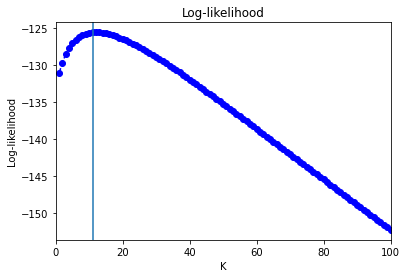

Optimal K is 6


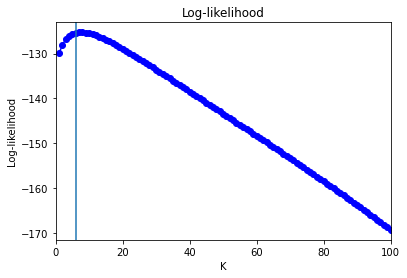

In [51]:
K = np.arange(1, 101, 1)

log_likelihoods_normal = try_ks(K)
plot_log_likelihood(K, log_likelihoods_normal)

log_likelihoods_mov = try_ks(K, mov_flag=True)
plot_log_likelihood(K, log_likelihoods_mov)

In [53]:
def bestK(log_likelihoods):
    '''
    TODO: add comment
    '''
    return log_likelihoods.index(max(log_likelihoods))

In [28]:
# Get ratings 
allratings = run_tournament3(fulldf, K=bestK(log_likelihoods_normal))
allratings.sort_values(by='ratings', ascending = False)[0:25]



,ratings
Eklent Kaci,1701.649697
Jayson Shaw,1692.910221
Joshua Filler,1650.774312
Fedor Gorst,1643.761536
Niels Feijen,1643.455154
Shane Van Boening,1637.251895
Albin Ouschan,1633.608892
Mario He,1613.381724
Dennis Orcollo,1610.190063
David Alcaide,1604.546076


In [29]:
players.value_counts()[list(allratings.sort_values(by='ratings', ascending = False)[0:25].index)]


Eklent Kaci               117
Jayson Shaw               118
Joshua Filler             108
Fedor Gorst                85
Niels Feijen              141
Shane Van Boening         167
Albin Ouschan             119
Mario He                   87
Dennis Orcollo             82
David Alcaide             101
Liu Haitao                 50
Denis Grabe                91
Ralf Souquet              122
Carlo Biado                60
Ko Pin Yi                  69
Ko Ping-Chung              58
Maximilian Lechner         55
Francisco Sanchez Ruiz     84
Mieszko Fortunski          59
Jeffrey de Luna            48
Alex Kazakis               95
Jeffrey Ignacio            46
Darren Appleton            94
Jung-Lin Chang             25
Mateusz Sniegocki          66
dtype: int64

In [30]:
allratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-40:len(players.value_counts())]

,ratings
Chris Lawson,1479.857618
Tony Chohan,1479.795060
Michael Yednak,1479.765461
Mohammed Hassan,1479.511247
Ali Abdulhadi Almeri,1479.490721
Ivar Saris,1479.472184
Jason Theron,1479.369746
Mohammad Soufi,1479.333461
Gabriel Syarov,1479.162393
Maksim Dudanets,1478.906472


In [31]:
players.value_counts()[list(allratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-25:len(players.value_counts())].index)]

Ken Thompson              4
Nadim Okbani              4
Carlos Cabello            4
Lenny Rakers              4
Mark Todd                 4
Ali al-Obaidly           11
Abder Rehman Mebarki      4
Roberto Gomez            17
Tomasz Kaplan            35
Luu Minh Phuc            11
Mariusz Skoneczny        13
Alejandro Carvajal        7
Meshaal al-Murdhi         7
Huidji See               11
Kostas Koukiadakis       20
Enrique Rojas             5
Bashar Hussain           13
Stevie Moore              5
Gary Lutman               7
Sundeep Gulati            5
Adam Mscisz               5
Earl Strickland          19
Robert Hart               6
Abdul Latif al-Fawal     11
Mohammad-Ali Berjaoui    11
dtype: int64

In [47]:
# Filter ratings 
CLPratings = allratings.iloc[np.array(names)]
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
CLPratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1692.377709
Niels Feijen,1645.963739
Albin Ouschan,1631.188968
Ralf Souquet,1596.112273
David Alcaide,1595.968819
Denis Grabe,1590.186235
Alex Kazakis,1582.270268
Mieszko Fortunski,1572.933758
Darren Appleton,1568.380104
Casper Matikainen,1554.256052


In [48]:
get_accuracy(data, CLPratings)

0.6197916666666666

In [34]:
# TODO: functionalize

accuracies = []
for k in K: 
    # Get ratings 
    allratings = run_tournament3(fulldf, K=k)
    
    # Filter ratings 
    CLPratings = allratings.iloc[np.array(names)]
#     CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
    CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
    
    accuracies.append(get_accuracy(data, CLPratings))

Optimal K is 19


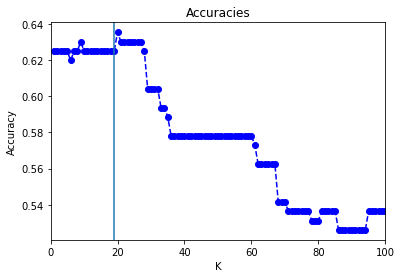

In [35]:
ax = plt.axes()
ax.plot(K, accuracies, '--bo')
ax.axvline(accuracies.index(max(accuracies)))
ax.set(xlim=(0, 100),
       xlabel='K', ylabel='Accuracy',
       title='Accuracies');

print("Optimal K is " + str(accuracies.index(max(accuracies))))

# Margin of Victory Adjustment

In [54]:
def get_score_diff(row):
    '''
    Score difference for a match.
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    return np.abs(row['playerARacks'] - row['playerBRacks'])

# Margin of Victory Multiplier = LN(ABS(PD)+1) * (2.2/((ELOW-ELOL)*.001+2.2))


def run_tournament_mov(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020).
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        # Add margin of victory multiplier to K
        # https://math.stackexchange.com/questions/850002/improving-the-elo-rating-system-to-account-for-game-results
        mov = np.log(get_score_diff(row) + 1) * (2.2 / ((elo_ratings[winner] - elo_ratings[loser]) * 0.001 + 2.2))
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K * mov, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

In [55]:
# Use best K determined by maximizing the log-likelihood
ratings_mov = run_tournament_mov(fulldf, K=bestK(log_likelihoods_mov))
ratings_mov.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1692.377709
Jayson Shaw,1661.360214
Joshua Filler,1647.454976
Niels Feijen,1645.963739
Shane Van Boening,1638.537159
Albin Ouschan,1631.188968
Fedor Gorst,1628.217354
Dennis Orcollo,1599.385870
Mario He,1597.972636
Carlo Biado,1597.740646


# Update Posterior Ratings after Predator CLP

In [818]:
def run_tournament_with_prior_ratings(data, priorratings, ELO_WIDTH = ELO_WIDTH, K=bestK):
    

    # Initialize Elo Ratings
    elo_ratings = priorratings

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        k=K
#         if row['isSemi'] == True: 
#             k = K*2
#         elif row['isFinal'] == True: 
#             k = K*3
#         else: 
#             k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings.loc[winner][0], elo_ratings.loc[loser][0], k, ELO_WIDTH)
        elo_ratings.loc[winner][0] = new_winner_rating
        elo_ratings.loc[loser][0] = new_loser_rating
    return(elo_ratings)

In [819]:
posterior_ratings = run_tournament_with_prior_ratings(data, priorratings = CLPratings)

In [820]:
posterior_ratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,2076.056222
Niels Feijen,1852.814433
Albin Ouschan,1848.922686
Denis Grabe,1818.641877
David Alcaide,1803.561558
Mieszko Fortunski,1790.536415
Naoyuki Oi,1776.267705
Alex Kazakis,1769.146260
Casper Matikainen,1746.929839
Billy Thorpe,1722.042210


# Varying K 

In [697]:
# Elo Rating System 
# Constants
INITIAL_RATING = 0
ELO_WIDTH = 400

def expected_Glickman(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** (-1 * (A - B) / elo_width))
    return( proba )

def standard_update_elo_Glickman(Rpre, Ropp, S, k, m0, elo_width):
    expected_win = expected(Rpre, Ropp, elo_width)
    T = 14
    if (k *(S-expected_win)) <= (T * np.sqrt(m0)[0]): 
        B = 0
    else: 
        B = k *(S-expected_win) - (T * np.sqrt(m0)[0])
    Rpost = Rpre + k *(S-expected_win) + B
    return Rpost

def special_update_elo_Glickman(Rpre, Ropp, N, WL, m, elo_width):
    Rpost = (N * Rpre + m * Ropp + WL*elo_width)/(N + m)
    return Rpost





def run_tournament_varyingK(data, priorratings, priorgames, ELO_WIDTH = ELO_WIDTH, dictflag=False, consolidation = False):
    
    # Initialize Elo Ratings
    tournamentgames = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    elo_ratings = priorratings
    WLrecord = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    opponentrating = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        playerA = row["playerA"]
        playerB = row["playerB"]
        if consolidation: 
            playerA = switcher(row["playerA"])
            playerB = switcher(row["playerB"])
            
        tournamentgames.loc[playerA] += 1
        tournamentgames.loc[playerB] += 1
        mA = tournamentgames.loc[playerA]
        mB = tournamentgames.loc[playerB]
#         print(tournamentgames)
        
        Apre = elo_ratings.loc[playerA][0]
        Bpre = elo_ratings.loc[playerB][0]
        SA = row['playerARacks'] > row['playerBRacks'] 
        SB = row['playerBRacks'] > row['playerARacks'] 
        
        if SA: 
            WLrecord.loc[playerA] += 1
        else: 
            WLrecord.loc[playerA] -= 1
            
        if SB: 
            WLrecord.loc[playerB] += 1
        else: 
            WLrecord.loc[playerB] -= 1

        if dictflag:
            NA = priorgames.loc[playerA][0]
            NB = priorgames.loc[playerB][0]
        else:
            NA = priorgames[playerA]
            NB = priorgames[playerB]
            

        
        if NA < 50: 
            ANr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Apre)**2)
        else: 
            ANr = 50
        if NB < 50: 
            BNr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Bpre)**2)
        else: 
            BNr = 50
            
        Ne = min(ANr, BNr)
        
        if NA <=8: 
            Apost = special_update_elo_Glickman(Apre, Bpre, NA, WLrecord.loc[playerA][0], mA, ELO_WIDTH)
        else: 
            K = 800/ (NA + Ne)
            Apost = standard_update_elo_Glickman(Apre, Bpre, SA, K, mA, ELO_WIDTH)
        
        if NB <=8: 
            Bpost = special_update_elo_Glickman(Bpre, Apre, NB, WLrecord.loc[playerB][0], mB, ELO_WIDTH)
        else: 
            K = 800/ (NB + Ne)
            Bpost = standard_update_elo_Glickman(Bpre, Apre, SB, K, mB, ELO_WIDTH)
        
        if dictflag:
            priorgames.loc[playerA][0] += 1
            priorgames.loc[playerB][0] += 1 
        else:
            priorgames[playerA] += 1
            priorgames[playerB] += 1
        
        elo_ratings.loc[playerA][0] = Apost
        elo_ratings.loc[playerB][0] = Bpost
    return(elo_ratings)



In [698]:
players.value_counts()[np.array(names)]

Chris Melling         54
Albin Ouschan         73
Kelly Fisher           2
Eklent Kaci          125
Niels Feijen          88
Ralf Souquet          82
Chris Robinson         9
Mieszko Fortunski     42
David Alcaide        100
Darren Appleton       81
Billy Thorpe          23
Naoyuki Oi            43
Kristina Tkach         1
Roberto Gomez         17
Marc Bijsterbosch     23
Alex Kazakis         108
Casper Matikainen     81
Denis Grabe           76
Jasmin Ouschan         4
dtype: int64

In [699]:
playergames = players.value_counts()
print(playergames)



Shane Van Boening       132
Konrad Juszczyszyn      131
Eklent Kaci             125
Ruslan Chinakhov        120
Mateusz Sniegocki       119
                       ... 
Angel Gabriel Acosta      1
Ang Tuan Nguyen           1
Bogdan Alin Stoian        1
Marlon Villamor           1
Hugo Duivenvoorden        1
Length: 1144, dtype: int64


In [700]:
ratings = run_tournament_varyingK(data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,2055.898817
Albin Ouschan,1996.975385
Niels Feijen,1980.624883
Naoyuki Oi,1970.884440
Alex Kazakis,1929.651850
Ralf Souquet,1910.175430
Darren Appleton,1901.292953
Mieszko Fortunski,1893.443374
Chris Melling,1879.667599
David Alcaide,1859.311249


In [701]:
allratings

,ratings
Shane Van Boening,2047.261892
Konrad Juszczyszyn,2111.007685
Eklent Kaci,2042.723933
Ruslan Chinakhov,1805.061107
Mateusz Sniegocki,2074.927597
...,...
Angel Gabriel Acosta,1562.319995
Ang Tuan Nguyen,1414.623308
Bogdan Alin Stoian,1100.000000
Marlon Villamor,1432.737013


In [754]:
# init = pd.DataFrame(np.zeros_like(allratings), index = allratings.index).rename(columns={0:'ratings'})
playersgreaterthan10 = players.value_counts()[players.value_counts() > 10]

playergamedictionary = {}

players.value_counts().index.unique()

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        print(i)
        pass
    else:
        playergamedictionary[i] = "Player " + str(players.value_counts()[players.value_counts().index == i][0])

playergamedictionary
fulldf_version = fulldf.copy()
fulldf_version


Chris Robinson
Jasmin Ouschan
Kelly Fisher
Kristina Tkach


,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14 00:00:00,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14 00:00:00,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14 00:00:00,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14 00:00:00,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14 00:00:00,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4781,4781,417,NaN,2020-02-22 12:00:00,Eklent Kaci,9,Maximilian Lechner,0,2020 EuroTour Treviso
4782,4782,418,NaN,2020-02-22 12:00:00,Mickey Krause,4,Mateusz Sniegocki,9,2020 EuroTour Treviso
4783,4783,419,NaN,2020-02-22 14:00:00,Fedor Gorst,3,Jayson Shaw,9,2020 EuroTour Treviso
4784,4784,420,NaN,2020-02-22 15:30:00,Eklent Kaci,9,Mateusz Sniegocki,6,2020 EuroTour Treviso


In [755]:
playergamedictionary

{'Bora Anar': 'Player 10',
 'Jani Siekkinen': 'Player 10',
 'Elliott Sanderson': 'Player 10',
 'Robbie Capito': 'Player 10',
 'Mariusz Skoneczny': 'Player 10',
 'Aleksa Pecelj': 'Player 10',
 'Szu-Ting Kuo': 'Player 10',
 'Moritz Lauwereyns': 'Player 10',
 'Michael Yednak': 'Player 10',
 'Artem Koshovyi': 'Player 10',
 'Stanimir Ruslanow': 'Player 10',
 'Arjan Matrizi': 'Player 10',
 'Satoshi Kawabata': 'Player 10',
 'Francesco Candela': 'Player 10',
 'Abdullah al-Yousif': 'Player 9',
 'Donny Branson': 'Player 9',
 'Tom Teriault': 'Player 9',
 'Do The Kien': 'Player 9',
 'Kenichi Uchigaki': 'Player 9',
 'Liu Cheng Chieh': 'Player 9',
 'Blake Baker': 'Player 9',
 'Menelaos Lolas': 'Player 9',
 'Osman Sanlisoy': 'Player 9',
 'Han Haoxiang': 'Player 9',
 'Salah Al Riwani': 'Player 9',
 'Raj Hundal': 'Player 9',
 'Sergey Lutsker': 'Player 9',
 'Ali Maghsoud': 'Player 9',
 'Jeppe Thyde': 'Player 9',
 'Sean Morgan': 'Player 9',
 'Henrique Correia': 'Player 9',
 'Pepijn DeWit': 'Player 9',
 '

In [756]:
def switcher(argument):
        switcher = playergamedictionary

        # get() method of dictionary data type returns 
        # value of passed argument if it is present 
        # in dictionary otherwise second argument will
        # be assigned as default value of passed argument
        val = switcher.get(argument, "nothing")
        if val == "nothing":
            return argument
        else:
#             print(val)
            return val
def consolidatestrings(series):
    
    lst = []
    for idx, item in enumerate(series): 
        lst.append(switcher(item))
#     print(lst)
    return(lst)
   
    

fulldf_version["playerA"] = consolidatestrings(fulldf_version["playerA"])
fulldf_version["playerB"] = consolidatestrings(fulldf_version["playerB"])

fulldf_version

,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14 00:00:00,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14 00:00:00,Ernesto Dominguez,11,Player 7,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14 00:00:00,Player 1,11,Player 4,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14 00:00:00,Player 2,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14 00:00:00,Francisco Bustamante,11,Player 1,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4781,4781,417,NaN,2020-02-22 12:00:00,Eklent Kaci,9,Maximilian Lechner,0,2020 EuroTour Treviso
4782,4782,418,NaN,2020-02-22 12:00:00,Mickey Krause,4,Mateusz Sniegocki,9,2020 EuroTour Treviso
4783,4783,419,NaN,2020-02-22 14:00:00,Fedor Gorst,3,Jayson Shaw,9,2020 EuroTour Treviso
4784,4784,420,NaN,2020-02-22 15:30:00,Eklent Kaci,9,Mateusz Sniegocki,6,2020 EuroTour Treviso


In [764]:
filtered_list = list(set(playergamedictionary.values()))
for i in list(players.value_counts()[players.value_counts() > 10].index):
    filtered_list.append(i)

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        filtered_list.append(i)
    

# filtered_list

[8, 1, 13, 0, 2, 5, 18, 7, 9, 6, 16, 3, 15, 14, 11, 4, 10, 12, 17]

In [761]:
# Get ratings 


init = pd.DataFrame(np.zeros(len(filtered_list)), index = index).rename(columns={0:'ratings'})
allratings = run_tournament_varyingK(fulldf_version, init + 1500, init, dictflag =True, consolidation=True)
allratings.sort_values(by='ratings', ascending = False)[0:40]


,ratings
Li He Wen,2312.065429
Antonio Lining,2292.075119
Francisco Bustamante,2281.337212
Yu-Lung Chang,2224.186972
Roland Garcia,2218.217781
Wu Kun-Lin,2153.937696
Oliver Ortmann,2144.204593
Kai-Lun Hsu,2124.493328
James Aranas,2119.697503
Liu Ri Teng,2097.791497


In [765]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in allratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(allratings.index == player)[0][0])
playersindex
names

[46,
 30,
 188,
 12,
 20,
 24,
 186,
 54,
 17,
 26,
 100,
 53,
 189,
 123,
 101,
 16,
 25,
 28,
 187]

In [769]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = allratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

# # Filter ratings 
# CLPratings = allratings.iloc[np.array(names)]
# # CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
# CLPratings = CLPratings.set_index( index )
CLPratings.sort_values(by='ratings', ascending = False)

['Chris Melling', 'Albin Ouschan', 'Kelly Fisher', 'Eklent Kaci', 'Niels Feijen', 'Ralf Souquet', 'Chris Robinson', 'Mieszko Fortunski', 'David Alcaide', 'Darren Appleton', 'Billy Thorpe', 'Naoyuki Oi', 'Kristina Tkach', 'Roberto Gomez', 'Marc Bijsterbosch', 'Alex Kazakis', 'Casper Matikainen', 'Denis Grabe', 'Jasmin Ouschan']
                       ratings
Chris Melling      1894.953504
Albin Ouschan      1899.952033
Kelly Fisher       1728.205694
Eklent Kaci        1991.807722
Niels Feijen       1849.330418
Ralf Souquet       1910.653933
Chris Robinson     1639.409561
Mieszko Fortunski  1940.487671
David Alcaide      1848.802582
Darren Appleton    1805.418114
Billy Thorpe       1530.079361
Naoyuki Oi         1883.549014
Kristina Tkach     1266.533214
Roberto Gomez      1723.302031
Marc Bijsterbosch  1509.745363
Alex Kazakis       1865.258891
Casper Matikainen  1831.001462
Denis Grabe        1765.244747
Jasmin Ouschan     1624.586179


,ratings
Eklent Kaci,1991.807722
Mieszko Fortunski,1940.487671
Ralf Souquet,1910.653933
Albin Ouschan,1899.952033
Chris Melling,1894.953504
Naoyuki Oi,1883.549014
Alex Kazakis,1865.258891
Niels Feijen,1849.330418
David Alcaide,1848.802582
Casper Matikainen,1831.001462


In [770]:
def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
#         print(proba)
    
        loglikelihood += math.log(proba)

        
    return(loglikelihood)

In [771]:
get_loglikelihood(data, CLPratings)

-142.3833440276898

In [772]:
ratings = run_tournament_varyingK(data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,1994.994305
Albin Ouschan,1902.738178
Chris Melling,1900.842405
Ralf Souquet,1889.218330
Mieszko Fortunski,1887.564431
Naoyuki Oi,1875.184791
David Alcaide,1865.127168
Alex Kazakis,1862.206402
Niels Feijen,1855.517784
Casper Matikainen,1812.320480



# Sandbox Code 

In [70]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [69]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

In [469]:

def run_tournament(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, k=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating

    return(elo_ratings)

In [470]:
ratings = run_tournament()

KeyError: 'WinnerName'

In [100]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Shannon Murphy,1475.0
Robby Foldvari,1475.0
Jang Moonseok,1475.0
Francois Ellis,1475.0
Himanshu Jain,1475.0
...,...
Albin Ouschan,800.0
Jayson Shaw,775.0
Alex Pagulayan,750.0
Dennis Orcollo,750.0


In [101]:
# Train-Test Split
winnersgroup = data[data.Group == 8]
prelims = data[data.Group != 8]

In [102]:
ratingsPrelims = run_tournament(data=prelims)

KeyError: 'Kelly Fisher'

In [103]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


NameError: name 'ratingsPrelims' is not defined